In [2]:
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
from skimage.io import imread, imsave, imshow

from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from skimage.viewer import ImageViewer
from skimage.morphology import binary_dilation
from skimage.measure import find_contours
from scipy import ndimage as ndi

import cv2
from PIL import Image

from natsort import natsorted

/home/nathan/anaconda3/lib/python3.7/site-packages/skimage/viewer/utils/__init__.py:1: UserWarning: Recommended matplotlib backend is `Agg` for full skimage.viewer functionality.
  from .core import *


### Image path

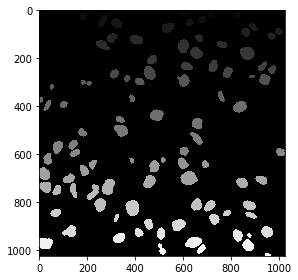

In [9]:
image_path = os.path.normpath("/home/nathan/analysis/seg_tidy/")
image_name = "s_a.png"
image = imread(os.path.normpath(os.path.join(image_path, image_name)))
imshow(image)

# label image and erode each segment

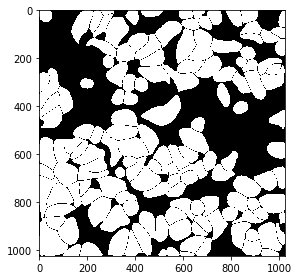

In [161]:
segmentation = image
binary_segmentation = np.zeros(segmentation.shape, dtype=np.bool)
labels = list(np.unique(segmentation).astype(np.int))
labels.remove(0)
for i in labels:
    mask = segmentation == i
    mask_eroded = ndi.binary_erosion(mask, iterations=1)
    binary_segmentation = np.logical_or(binary_segmentation, mask_eroded)

imshow(binary_segmentation)
im = Image.fromarray(binary_segmentation)
im.save("your_file.jpeg")

# label and erode over whole stack

In [4]:
image_path = os.path.normpath("/home/nathan/data/kraken/fucci/2017_10_18/pos16/other_mask_data/cellpose_nuclear/non_binary_masks")
image_list = [m for m in os.listdir(image_path) if m.endswith('.png')]
image_list = natsorted(image_list)

for image_name in image_list:
    segmentation = imread(os.path.normpath(os.path.join(image_path, image_name)))
    
    binary_segmentation = np.zeros(segmentation.shape, dtype=np.bool)
    labels = list(np.unique(segmentation).astype(np.int))
    labels.remove(0)
    for i in labels:
        mask = segmentation == i
        mask_eroded = ndi.binary_erosion(mask, iterations=1)
        binary_segmentation = np.logical_or(binary_segmentation, mask_eroded)
    im = Image.fromarray(binary_segmentation)
    output_name = image_name.replace('.tif.png', '.tif')
    output_dir = '/home/nathan/data/kraken/fucci/2017_10_18/pos16/other_mask_data/cellpose_nuclear/binary_masks'
    output = os.path.join(output_dir, output_name)
    im.save(output)

In [129]:
# image already labelled
#n_labels = np.amax(image)
#for i in n_labels:
coords = np.where(image == 9)
#print(coords[0])#, coords[1])
x = coords[0]
y = coords[1]
print(x,y)



new_image = np.zeros((1024,1024), np.uint8)
new_image
lone_segment = np.insert(new_image, [x[0],y[0]], 15)

#print(new_image)
print(lone_segment)
#imsave('image.png',lone_segment)

[ 0  0  0 ... 50 50 50] [ 4  5  6 ... 28 29 30]
[15  0  0 ...  0  0  0]


In [ ]:
imsave('image.png', image)
img = cv2.imread('s_a.png',0)
kernel = np.ones((5,5),np.uint8)
erosion = cv2.erode(img,kernel,iterations = 3)
imsave('erosion.jpg',erosion)

# find edges using marching squares

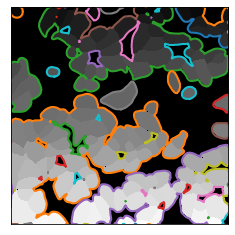

In [17]:
contours = find_contours(image, 0.01)
r = image

fig, ax = plt.subplots()
ax.imshow(r, cmap=plt.cm.gray)

for n, contour in enumerate(contours):
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)

ax.axis('image')
ax.set_xticks([])
ax.set_yticks([])
plt.show()

# find edges using sobel/laplacian

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


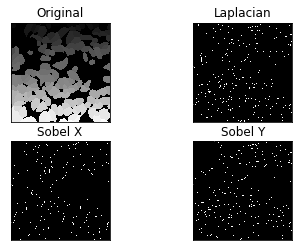

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


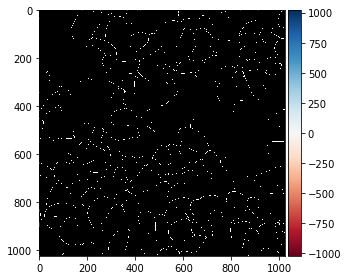

In [124]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# loading image
#img0 = cv2.imread('SanFrancisco.jpg',)
img = cv2.imread('/home/nathan/analysis/seg_tidy/s_a.png')

# converting to gray scale
gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# remove noise
#img = cv2.GaussianBlur(gray,(3,3),0)

# convolute with proper kernels
laplacian = cv2.Laplacian(img,cv2.CV_64F)
sobelx = cv2.Sobel(img,cv2.CV_64F,1,0,ksize=1)  # x
sobely = cv2.Sobel(img,cv2.CV_64F,0,1,ksize=1)  # y

plt.subplot(2,2,1),plt.imshow(img,cmap = 'gray')
plt.title('Original'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,2),plt.imshow(laplacian,cmap = 'gray')
plt.title('Laplacian'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,3),plt.imshow(sobelx,cmap = 'gray')
plt.title('Sobel X'), plt.xticks([]), plt.yticks([])
plt.subplot(2,2,4),plt.imshow(sobely,cmap = 'gray')
plt.title('Sobel Y'), plt.xticks([]), plt.yticks([])

plt.show()

edge_image = laplacian + sobelx + sobely
imshow(edge_image)

# euc distance transform, erasure of narrow regions, erasure of small objects, then dilation to regain lost areas

In [158]:
#imsave('s_0.tif', image)

euc_distance = ndi.distance_transform_edt(image)
min_distance = 6 #this parameter says that all regions <8 pixels from background will be erased
refined_mask = np.zeros_like(euc_distance)
refined_mask[euc_distance < min_distance] = 0 
refined_mask[euc_distance > min_distance] = 1

imsave('distance_transform_erasure.png', refined_mask)

label_objects, nb_labels = ndi.label(refined_mask)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 250 #minimum size object deletion
mask_sizes[0] = 0 #Background?
cleaned = mask_sizes[label_objects]

imsave('dte_cleaned.tif', cleaned)

#print(sizes)
#print(mask_sizes)
#imshow(refined_mask)

dilated = ndi.morphology.binary_dilation(cleaned, iterations = 6)
#imshow(dilated)
imsave('dte_c_dilated.tif', dilated)print(len(images))


Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: UserWarning: dte_cleaned.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: dte_c_dilated.tif is a boolean image: setting True to 1 and False to 0


# watershed 

12 original segments found
7 unique segments found


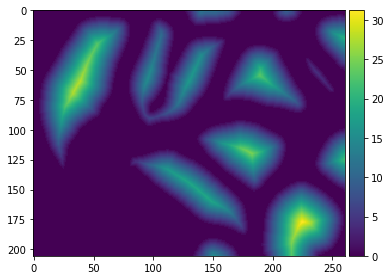

In [121]:
## label original
L, n = ndi.label(image)
print(n, "original segments found")

# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
euc_distance = ndi.distance_transform_edt(image)

imshow(euc_distance)
distance_between_peaks = 30
peaks = peak_local_max(euc_distance, indices=False, min_distance=distance_between_peaks,labels=image)
#imshow(peaks)
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndi.label(peaks, structure=np.ones((3, 3)))[0]
labels = watershed(euc_distance, markers, mask=image)
print("{} unique segments found".format(len(np.unique(labels)) - 1))

#imshow(labels)


#imsave("watershed_output.tif", labels)
#imsave("distance_transform.png", D)



# remove small objects

[28903   478   193   826  5392  4269  2567   223  2865   877  3299  3456
   418]
[False  True False  True  True  True  True False  True  True  True  True
  True]


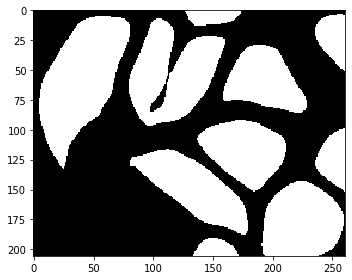

In [119]:
label_objects, nb_labels = ndi.label(euc_distance)
sizes = np.bincount(label_objects.ravel())
mask_sizes = sizes > 250 #minimum size object deletion
mask_sizes[0] = 0 #Background?
cleaned = mask_sizes[label_objects]

imshow(cleaned)

print(sizes)
print(mask_sizes)


#### Iterative loop to trim down full stack using morphological opening

In [6]:
image_path = os.path.normpath("C:/Users/Nathan/Documents/data/fucci/labels_v5/")
output_path = os.path.normpath("C:/Users/Nathan/Documents/data/fucci/labels_v5_sexedup")
image_names = [f for f in os.listdir(image_path) if f.endswith('.tif')]
strength = 10 # number of iterations to perform 
kernel = np.ones((3,3),np.uint8)
for i, image_name in enumerate(image_names):
        image = imread(os.path.normpath(os.path.join(image_path, image_name))) 
        opening = cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel, iterations = strength)
        imsave(os.path.normpath(os.path.join(output_path, image_name)), opening)

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_0.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_1.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_10.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_100.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_1000.tif is a low contrast image
  if __name__ == '__main__':
C:\U

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_1045.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_1046.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_1047.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_1048.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_1049.tif is a low contrast image
  if __name__ == '__main

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_11.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_110.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_111.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_112.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_113.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_149.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_15.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_150.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_151.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_152.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_2.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_20.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_200.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_201.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_202.tif is a low contrast image
  if __name__ == '__main__':
C:\

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_241.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_242.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_243.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_244.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_245.tif is a low contrast image
  if __name__ == '__main__':


C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_287.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_288.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_289.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_29.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_290.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_326.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_327.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_328.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_329.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_33.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_368.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_369.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_37.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_370.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_371.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_413.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_414.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_415.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_416.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_417.tif is a low contrast image
  if __name__ == '__main__':


C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_459.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_46.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_460.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_461.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_462.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_496.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_497.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_498.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_499.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_5.tif is a low contrast image
  if __name__ == '__main__':
C:

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_536.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_537.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_538.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_539.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_54.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_58.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_580.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_581.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_582.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_583.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_626.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_627.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_628.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_629.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_63.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_667.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_668.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_669.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_67.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_670.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_703.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_704.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_705.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_706.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_707.tif is a low contrast image
  if __name__ == '__main__':


C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_745.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_746.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_747.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_748.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_749.tif is a low contrast image
  if __name__ == '__main__':


C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_787.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_788.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_789.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_79.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_790.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_841.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_842.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_843.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_844.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_845.tif is a low contrast image
  if __name__ == '__main__':


C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_880.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_881.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_882.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_883.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_884.tif is a low contrast image
  if __name__ == '__main__':


C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_918.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_919.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_92.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_920.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_921.tif is a low contrast image
  if __name__ == '__main__':
C

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_96.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_960.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_961.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_962.tif is a low contrast image
  if __name__ == '__main__':
C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:9: UserWarning: C:\Users\Nathan\Documents\data\fucci\labels_v5_sexedup\s_963.tif is a low contrast image
  if __name__ == '__main__':
C

### Morphological opening seems to trim cells down to size! 

C:\Users\Nathan\anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: opening.png is a low contrast image
  


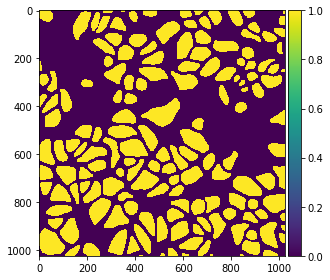

In [14]:
## first employ a morpholigical closing to fill any holes and a morphological opening to get rid of any negligible (noise) objects
#noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(image,cv2.MORPH_OPEN,kernel, iterations = 5)
imshow(opening)
imsave("opening.png", opening)

### Labels each segment different value

In [ ]:
                 
distance = ndi.distance_transform_edt(image)
local_maxi = peak_local_max(distance, indices=False, footprint=np.ones((1, 2)),labels=image)
print(np.ones((1, 2)))
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=image)

fig, axes = plt.subplots(ncols=3, figsize=(9, 3), sharex=True, sharey=True)
ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title('Overlapping objects')
ax[1].imshow(-distance, cmap=plt.cm.gray)
ax[1].set_title('Distances')
ax[2].imshow(labels, cmap=plt.cm.nipy_spectral)
ax[2].set_title('Separated objects')

for a in ax:
    a.set_axis_off()

fig.tight_layout()
plt.show()
imsave("watershed_test.tif", labels)

# iterate over whole stack, applying E.D.T., erasure, removal small regions, then dilation

In [166]:
path = "/home/nathan/data/fucci"
image_dir = "labels_v5"
image_path = os.path.join(path, image_dir)
#image_name = "s_0.tif"
#image = imread(os.path.normpath(os.path.join(image_path, image_name)))
#imshow(image)
output_dir = "labels_v5_sexedup"
image_output_path = os.path.join(path, output_dir)

try:
    # Create target Directory
        os.mkdir(image_output_path)
        print("Directory " , image_output_path ,  " Created ") 
except FileExistsError:
        print("Directory " , image_output_path ,  " already exists")
        
images = [i for i in os.listdir(image_path) if i.endswith('.tif')]

for i in images: 
    image = imread(os.path.join(image_path, i))
    euc_distance = ndi.distance_transform_edt(image)
    min_distance = 6 #this parameter says that all regions <8 pixels from background will be erased
    refined_mask = np.zeros_like(euc_distance)
    refined_mask[euc_distance < min_distance] = 0 
    refined_mask[euc_distance > min_distance] = 1

    #imsave('distance_transform_erasure.png', refined_mask)

    label_objects, nb_labels = ndi.label(refined_mask)
    sizes = np.bincount(label_objects.ravel())
    mask_sizes = sizes > 250 #minimum size object deletion
    mask_sizes[0] = 0 #Background?
    cleaned = mask_sizes[label_objects]

    #imsave('dte_cleaned.tif', cleaned)

    #print(sizes)
    #print(mask_sizes)
    #imshow(refined_mask)

    dilated = ndi.morphology.binary_dilation(cleaned, iterations = 6)
    #imshow(dilated)
    image_output_path_fn = os.path.join(image_output_path, i)
    imsave(image_output_path_fn, dilated)




Directory  /home/nathan/data/fucci/labels_v5_sexedup  already exists


/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_431.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_998.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_564.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_385.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_843.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/li

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_580.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_433.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_711.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_859.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_284.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/li

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_977.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_839.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_290.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_741.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_210.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/li

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_232.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_332.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_467.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_627.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_764.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/li

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_864.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_401.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_577.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_392.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_116.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/li

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_993.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_358.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_947.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_415.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_30.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_189.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_438.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_29.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_33.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1050.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_836.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_620.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_909.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_769.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_8.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1049.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_623.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_185.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_63.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_75.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_553.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_840.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_787.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_842.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_516.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/li

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_208.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_742.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_20.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_78.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_354.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_639.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_829.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1014.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_562.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_605.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/l

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_917.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1043.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_231.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_834.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_875.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/l

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_447.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_88.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_835.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_215.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_724.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_122.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_991.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_96.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_753.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_823.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_923.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_67.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_121.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_616.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_98.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1006.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_844.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_871.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1063.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_846.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_888.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_941.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_249.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_298.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_166.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/li

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_962.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_221.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_24.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_304.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_765.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_105.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_308.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_615.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_93.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_687.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_484.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_736.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_987.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_144.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_396.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/li

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_514.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_211.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1085.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1058.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_233.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1074.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_659.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_862.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_163.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_625.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/l

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1021.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_314.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_54.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_418.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_61.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1016.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_302.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_44.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_578.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1029.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/l

/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_791.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_575.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_647.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_1038.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:44: UserWarning: /home/nathan/data/fucci/labels_v5_sexedup/s_955.tif is a boolean image: setting True to 1 and False to 0
/home/nathan/anaconda3/l